In [1]:
import extract_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from scipy.signal import filtfilt, butter, iirnotch, welch
import math
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [15]:
data, words, starts, ends = extract_data.extract_data(r"C:\Users\lwing\College\Spring 2022\Senior Design\SilentSpeechDAS\fEMGData\mouthed_NewVocab_6_18th_set1.txt", r"C:\Users\lwing\College\Spring 2022\Senior Design\silent-speech\scripts\Mouthed_NewVocab_6_18th_set1_take3.txt")

2022-04-18T15:41:16.932-05


In [16]:
chan_1 = data[:,0]
chan_2 = data[:,1]
chan_3 = data[:,2]
chan_4 = data[:,3]
chan_5 = data[:,4]
chan_6 = data[:,5]
channel_data = [chan_1, chan_2, chan_3, chan_4, chan_5, chan_6]

### Creating target variable list

In [17]:
len(chan_1)

778050

In [18]:
y = np.zeros(778050)

In [19]:
print(starts)
print(ends)

[  7981  27185  32258  37573  42698  47792  52850  57606  62624  67605
  72813  77795  82976  88260  93447  98639 103917 109207 114416 120017
 125152 130312 135501 140541 145734 150798 155885 161193 166419 171546
 176590 188890 193716 199031 203980 208845 214106 219092 224113 230174
 235467 240689 245808 251248 256765 262049 267327 272717 277997 283005
 288146 294061 299269 304577 309648 314655 319782 324916 329826 335076
 340580 345762 351070 356388 362126 367329 372511 377606 382761 388031
 393287 398400 403535 408684 417375 422545 427270 432237 437282 441888
 446933 452299 457387 462629 467551 472761 477888 482934 488136 493374
 498768 503779 508932 514264 519513 524947 530233 535494 540642 545968
 554500 559463 564729 569845 575325 580763 586191 591353 596422 601668
 606978 612189 617636 622943 628173 633254 638489 643404 648684 653733
 658722 664200 669467 674796 679948 685582 690809 696144 702034 709421
 714210 719093 724264 729250 734318 739584 745882 750866 756043 761412
 76658

In [20]:
for i in range(len(starts)):
    y[starts[i]:ends[i]+1] = 1

In [21]:
print(np.count_nonzero(y))

236060


In [22]:
len(y)

778050

### Filtering

In [23]:
# [Band Pass to demonstrate most prominent frequency range]
low_cutoff = 20
high_cutoff = 450

filtered_data = [0,0,0,0,0,0]

for idx, channel in enumerate(channel_data):
    signal_meancorrect = channel - np.mean(channel)
    
    #60Hz Notch Filter for Power Line Noise
    b, a = iirnotch(60, 30, 1000)
    signal_notched = filtfilt(b, a, signal_meancorrect)

    # Fourth Order Butterworth 
    b, a = butter(10, [low_cutoff, high_cutoff], fs=1000, btype='bandpass')
    signal_filtered = filtfilt(b, a, signal_notched)

    #Rectify signal
    filtered_data[idx] = abs(signal_filtered)

In [24]:
print(chan_1)
print(filtered_data[0])

[-0.00958173 -0.00319391  0.         ... -0.00319391  0.00638782
  0.01596956]
[3.02249107e-05 5.67150400e-03 8.14509015e-03 ... 1.57520638e-02
 7.81051253e-03 9.45682595e-05]


### RMS

In [12]:
rms_window = deque([0,0,0,0,0])

for channel in filtered_data:
    for i, sample in enumerate(channel):
        rms_window.popleft()
        rms_window.append(sample)
        val = np.sqrt(sum(np.square(rms_window)/5))
        channel[i] = val

In [13]:
print(filtered_data[0])

[0.0001222  0.00142952 0.00200208 ... 0.06531884 0.06714348 0.06269261]


### Deleting extraneous data

In [25]:

for i in range(len(filtered_data)):
    filtered_data[i] = filtered_data[i][27185:767978]

In [26]:
len(filtered_data[0])

740793

In [27]:
y = y[27185:767978]

In [28]:
 #large window to average over
window = 40
        
        #overlap interval
skip = 20
        
ind1 = 0
ind2 = window
y_new = np.zeros(int(len(y)/20)+1)
i = 0
while ind1 < len(y):
            
    #remaining data less than window size, avoid array out of bounds
    if ind2 > len(y):
        ind2 = len(y)-1
                
    num_label = np.count_nonzero(y[ind1:ind2])
    if num_label > 19:
        y_new[i] = 1
    ind1 = ind1 + skip
    ind2 = ind2 + skip
    i = i+1

In [29]:
print(len(y))
print(len(y_new))

740793
37040


### Smoothing data as described by SAD doc

In [31]:
def rms(raw):
        rms_window = deque([0,0,0,0,0])
        rms_data = np.zeros(len(raw))
        for i, sample in enumerate(raw):
            rms_window.popleft()
            rms_window.append(sample)
            val = np.sqrt(sum(np.square(rms_window)/5))
            rms_data[i] = val
            
        return rms_data
    
    
#TO DO: MAKE SURE ARRAY OUT OF BOUNDS CHECK IS SUFFICIENT
def smooth(rms_data):
        
    #large window to average over; sampling rate is 1000 Hz; each sample is a millisecond
    window = 40
        
    #overlap interval
    skip = 20
        
    ind1 = 0
    ind2 = window
    #assuming that the packet size i.e. length of raw data and rms_data will be a multiple of 20
    downsampled = np.zeros(int(len(rms_data)/20)+1)
    i = 0
    while ind1 < len(rms_data):
            
        #remaining data less than window size, avoid array out of bounds
        if ind2 > len(rms_data):
            ind2 = len(rms_data)-1
                
        val = np.mean(rms_data[ind1:ind2], dtype=np.float64)
        downsampled[i] = val
        ind1 = ind1 + skip
        ind2 = ind2 + skip
        i = i+1
            
    return downsampled
        
def calculate(smoothed_envelope):
        
    return np.abs(np.diff(smoothed_envelope))

In [32]:
ready_data = [0,0,0,0,0,0]

for i in range(len(filtered_data)):
    data_rms = rms(filtered_data[i])
    res = smooth(data_rms)
    ready_data[i] = res

In [33]:
print(np.count_nonzero(ready_data[0]))

37040


In [34]:
len(ready_data[0])

37040

In [35]:
y_new = y_new[:37040]
print(len(y_new))

37040


In [36]:
print(np.count_nonzero(y_new))

11257


### Making dataframe and prepping for decision tree classifier

In [37]:
df = pd.DataFrame({
    
    "Chan1": ready_data[0],
    "Chan2": ready_data[1],
    "Chan5": ready_data[4],
    "Chan6": ready_data[5],
    "Y": y_new 
})

In [38]:
X = df[['Chan1', 'Chan2', 'Chan5', 'Chan6']]
Y = df[['Y']]

In [39]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

In [41]:
print(len(X_train))
print(len(X_test))


29632
7408


In [42]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [43]:
print(clf.score(X_test, y_test))

0.7671436285097192


In [44]:
print(np.mean(cross_val_score(clf, X_train, y_train)))

0.7782801164875771


In [45]:
predicted = clf.predict(X_test)

#I obtain the accuracy of this fold
ac=accuracy_score(predicted,y_test)
print(ac)
#I obtain the confusion matrix
cm=confusion_matrix(y_test, predicted)
print(cm)



0.7671436285097192
[[4192  988]
 [ 737 1491]]


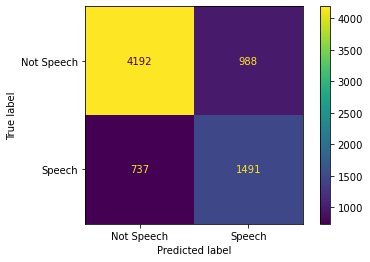

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cmd = ConfusionMatrixDisplay(cm,display_labels=['Not Speech','Speech'])
cmd.plot()